In [4]:
from itertools import product
import graspy as gp
import numpy as np
import pandas as pd
from hyppo.ksample import KSample
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm_notebook as tqdm

from numpy.linalg import norm

from src import estimate_embeddings
%matplotlib inline

sns.set_context("talk")

In [58]:
def rotate(x, angle):
    rads = (angle * np.pi) / 180
    rotated = np.array([
        np.cos(rads) * x[0] - np.sin(rads) * x[1],
        np.sin(rads) * x[0] + np.cos(rads) * x[1],
    ])
    
    return rotated

def find_angle(x, y, target):
    angle = np.arccos(target / (np.linalg.norm(x) * np.linalg.norm(y))) / np.pi * 180
    return angle

def generate_graphs_1(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Change magnitude, keep angle same
    Initial angle of 60 means half of p is off diagonal
    """
    assert (1. + effect_size) <= (1 / p)
    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    X3 = X2 * np.sqrt(1+effect_size)

    X = np.repeat(np.array([X1, X2]), block_size, axis=0)
    Y = np.repeat(np.array([X1, X3]), block_size, axis=0)
    
    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

def generate_graphs_2(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Keep magnitude, change angle
    Initial angle of 60 means half of p is off diagonal
    """
    assert (initial_angle + effect_size) <= 90.
    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    X3 = rotate(X1, initial_angle + effect_size)

    X = np.repeat(np.array([X1, X2]), block_size, axis=0)
    Y = np.repeat(np.array([X1, X3]), block_size, axis=0)
    
    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

def generate_graphs_3(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Change magnitude, keep angle same
    Initial angle of 60 means half of p is off diagonal
    """
    mag_effect = effect_size[0]
    angle_effect = effect_size[1]
    assert (1. + mag_effect) <= (1 / p)
    assert (initial_angle + angle_effect) <= 90.

    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    X3 = rotate(X1, initial_angle + angle_effect) * np.sqrt(1 + mag_effect)

    X = np.repeat(np.array([X1, X2]), block_size, axis=0)
    Y = np.repeat(np.array([X1, X3]), block_size, axis=0)
    
    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

def generate_graphs_4(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Initial angle of 60 means half of p is off diagonal
    """
    assert (1. + effect_size) <= (1 / p)
    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    off_diag = X1 @ X2
    X3 = X2 * np.sqrt(1+effect_size)
    X3 = rotate(X3, find_angle(X1, X3, off_diag)-initial_angle)

    X = np.repeat(np.array([X1, X2]), block_size, axis=0)
    Y = np.repeat(np.array([X1, X3]), block_size, axis=0)
    
    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

def plot(generate_func, p, effect_size, num_graphs, block_size, ax, title=None, method='omni', ax2=None):
    X, Y = generate_func(p, effect_size, block_size, num_graphs)
    embeddings = estimate_embeddings(X, Y, method, 2, True)
    Xhat = embeddings[:num_graphs]
    Yhat = embeddings[num_graphs:]
    
    node_labels = np.tile(['Block 1'] * block_size + ['Block 2'] * block_size, 2)
    graph_labels = ['Pop 1'] * (block_size * 2) + ['Pop 2'] * (block_size * 2)
        
    data = np.vstack([Xhat.mean(axis=0), Yhat.mean(axis=0)])
    
    sns.scatterplot(data[:, 0], data[:, 1], hue=graph_labels, style=node_labels, alpha=.5, ax=ax)
    if title is not None:
        ax.set_title(title)
    
    # plot differences
    if ax2 is not None:
        pop1 = Xhat.reshape(num_graphs, 2, block_size, 2).mean(axis=(0, 2))
        pop2 = Yhat.reshape(num_graphs, 2, block_size, 2).mean(axis=(0, 2))
        data2 = np.abs(pop1 - pop2)
    
        node_labels = ['Block 1'] + ['Block 2']
        sns.scatterplot(data2[:, 0], data2[:, 1], style=node_labels, alpha=.7, ax=ax2, label=title)
        
def plot2(generate_func, p, effect_size, num_graphs, block_size, axes, label, color):
    X, Y = generate_func(p, effect_size, block_size, num_graphs)
    
    for idx, method in enumerate(['omni', 'mase']):
        embeddings = estimate_embeddings(X, Y, method, 2, True)
        Xhat = embeddings[:num_graphs]
        Yhat = embeddings[num_graphs:]

        pop1 = Xhat.reshape(num_graphs, 2, block_size, 2).mean(axis=(0, 2))
        pop2 = Yhat.reshape(num_graphs, 2, block_size, 2).mean(axis=(0, 2))
        data2 = np.abs(pop1 - pop2)

        node_labels = ['Block 1'] + ['Block 2']
        sns.scatterplot(
            data2[:, 0], data2[:, 1], 
            style=node_labels, 
            alpha=.85,
            c=[color],
            ax=axes[idx], 
            label=label,
            s=200
        )
        
        axes[idx].set_title(method.upper())

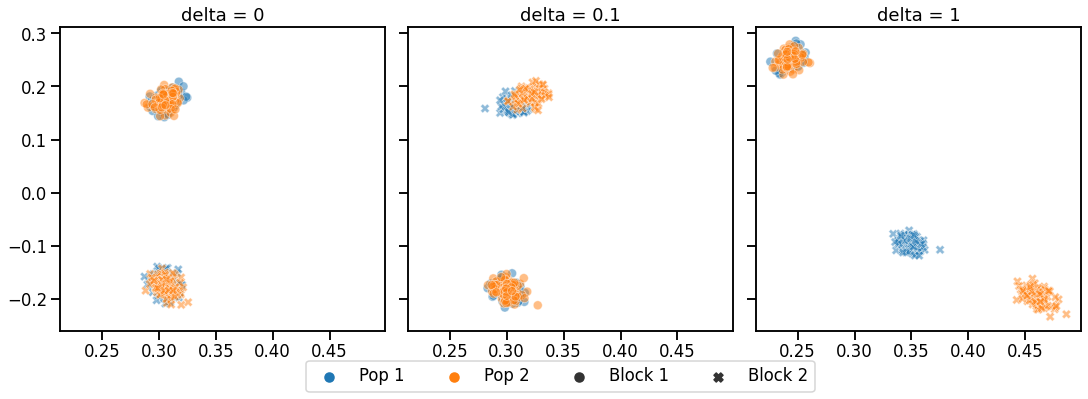

In [13]:
p = .25
num_graphs = 50
block_size = 100

effect_sizes = [0, .1, 1]
titles = [f"delta = {e}" for e in effect_sizes]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), constrained_layout=True, sharey=True, sharex=True)

for i in range(3):
    plot(generate_graphs_4, p, effect_sizes[i], num_graphs, block_size, axes[i], titles[i])
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
    
legend = fig.legend(
    handles, 
    labels,
    ncol = 7, 
    loc='lower center',
    bbox_to_anchor=(.515, -0.1),
    bbox_transform=fig.transFigure
)

fig.savefig("./figures/generate_graphs_4_latent_positions.png", dpi=300, bbox_inches='tight')

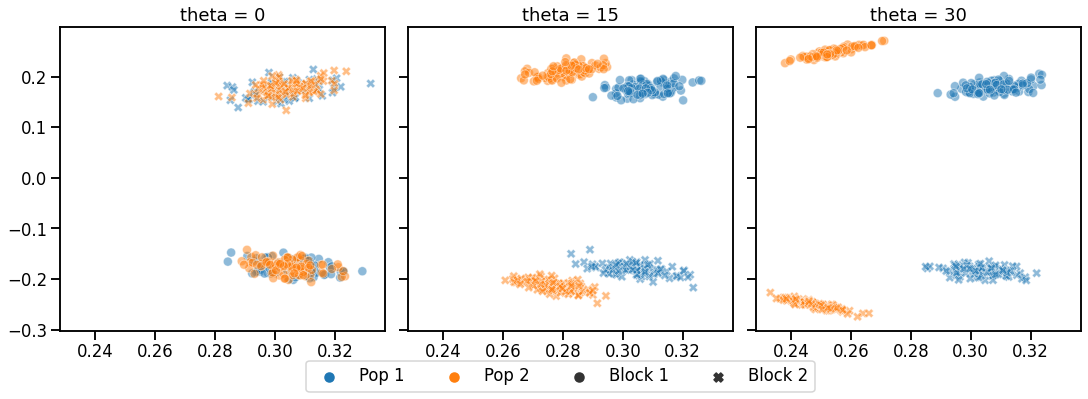

In [15]:
p = .25
num_graphs = 50
block_size = 100

effect_sizes = [0, 15, 30]
titles = [f"theta = {e}" for e in effect_sizes]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), constrained_layout=True, sharey=True, sharex=True)

for i in range(3):
    plot(generate_graphs_2, p, effect_sizes[i], num_graphs, block_size, axes[i], titles[i])
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
    
legend = fig.legend(
    handles, 
    labels,
    ncol = 7, 
    loc='lower center',
    bbox_to_anchor=(.515, -0.1),
    bbox_transform=fig.transFigure
)
fig.savefig("./figures/generate_graphs_2_latent_positions.png", dpi=300, bbox_inches='tight')

In [ ]:
p = .25
num_graphs = 50
block_size = 100

effect_sizes = [0, .1, 1]
titles = [f"delta = {e}" for e in effect_sizes]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), constrained_layout=True, sharey=True, sharex=True)

for i in range(3):
    plot(generate_graphs_1, p, effect_sizes[i], num_graphs, block_size, axes[i], titles[i])
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
    
legend = fig.legend(
    handles, 
    labels,
    ncol = 7, 
    loc='lower center',
    bbox_to_anchor=(.515, -0.1),
    bbox_transform=fig.transFigure
)
fig.savefig("./figures/generate_graphs_1_latent_positions.png", dpi=300, bbox_inches='tight')

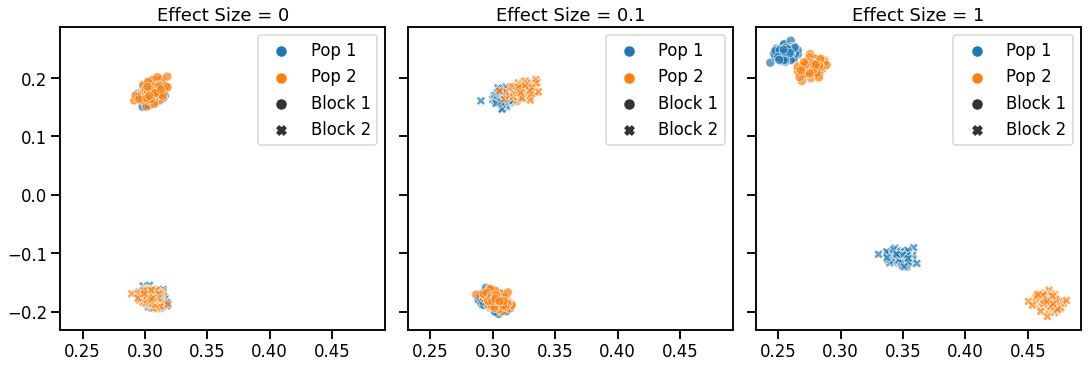

In [28]:
p = .25
num_graphs = 100
block_size = 100

effect_sizes = [0, .1, 1]
titles = [f"Effect Size = {e}" for e in effect_sizes]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), constrained_layout=True, sharey=True, sharex=True)

for i in range(3):
    plot(generate_graphs_1, p, effect_sizes[i], num_graphs, block_size, axes[i], titles[i])

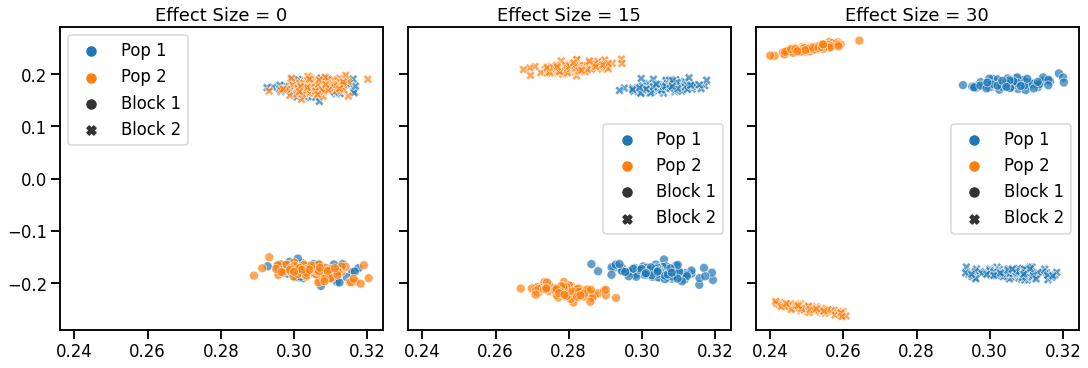

In [25]:
p = .25
num_graphs = 100
block_size = 100

effect_sizes = [0, 15, 30]
titles = [f"Effect Size = {e}" for e in effect_sizes]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), constrained_layout=True, sharey=True, sharex=True)

for i in range(3):
    plot(generate_graphs_2, p, effect_sizes[i], num_graphs, block_size, axes[i], titles[i])

(200, 400, 2)
(800, 2) 800 800
(200, 600, 2)
(1200, 2) 1200 1200
(200, 800, 2)
(1600, 2) 1600 1600


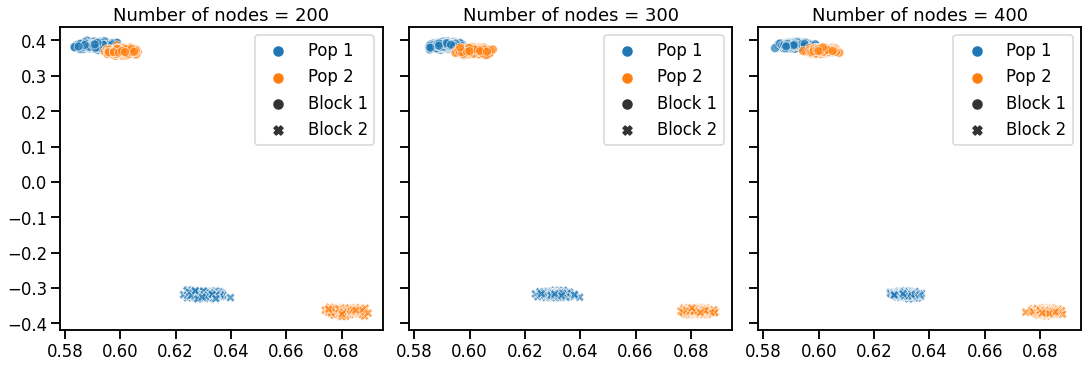

In [25]:
p = .5
num_graphs = 100
block_size = 100

effect_sizes = .1
block_sizes = [200, 300, 400]
titles = [f"Number of nodes = {e}" for e in block_sizes]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), constrained_layout=True, sharey=True, sharex=True)

for i in range(3):
    plot(generate_graphs_1, p, effect_sizes, num_graphs, block_sizes[i], axes[i], titles[i])
    handles, labels = axes[i].get_legend_handles_labels()
            axes[i].get_legend().remove()
    
legend = fig.legend(
    handles, 
    labels,
    ncol = 7, 
    loc='lower center',
    bbox_to_anchor=(.515, -0.1),
    bbox_transform=fig.transFigure
)

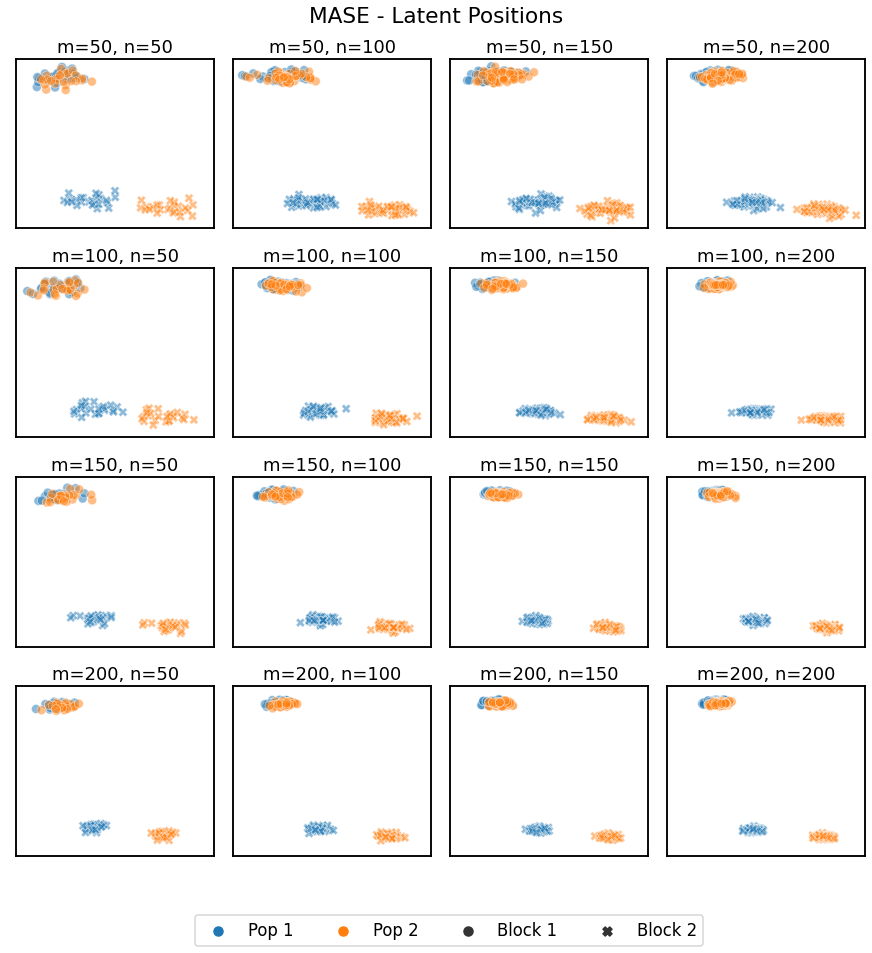

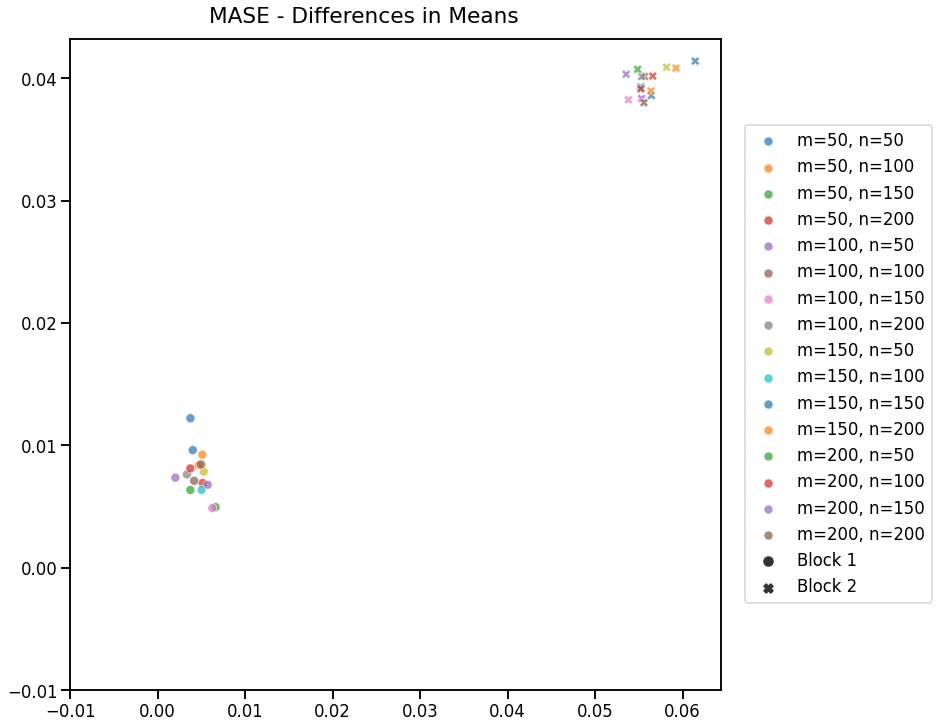

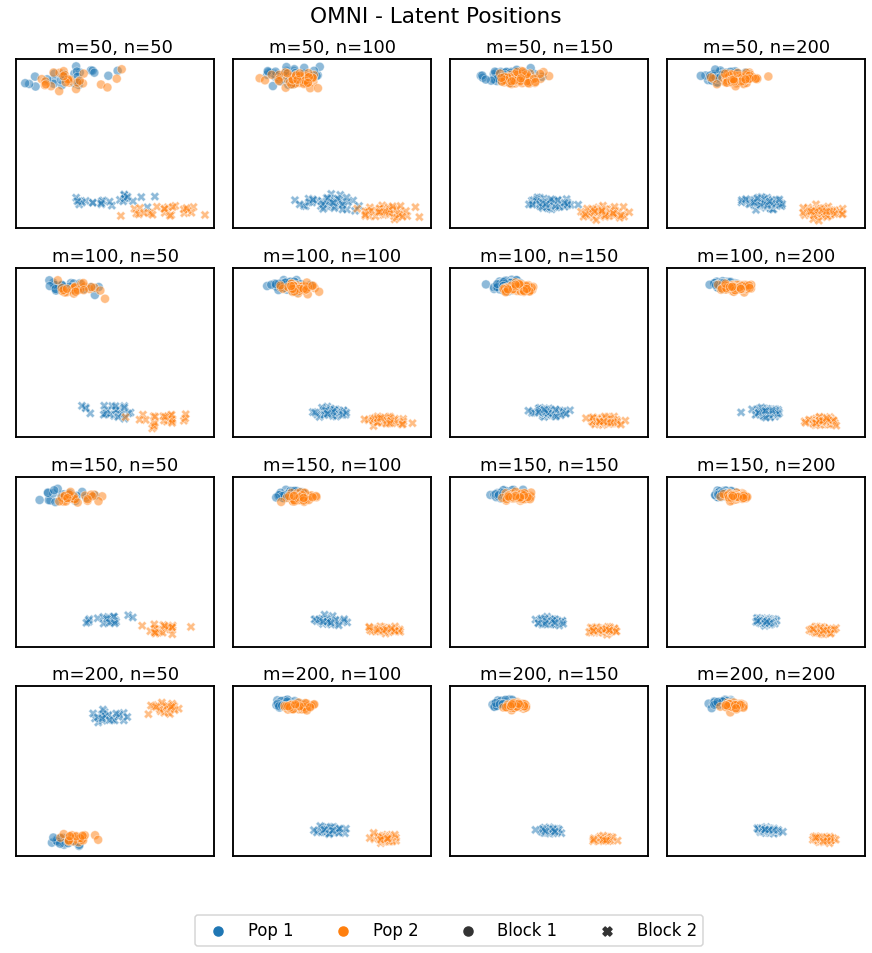

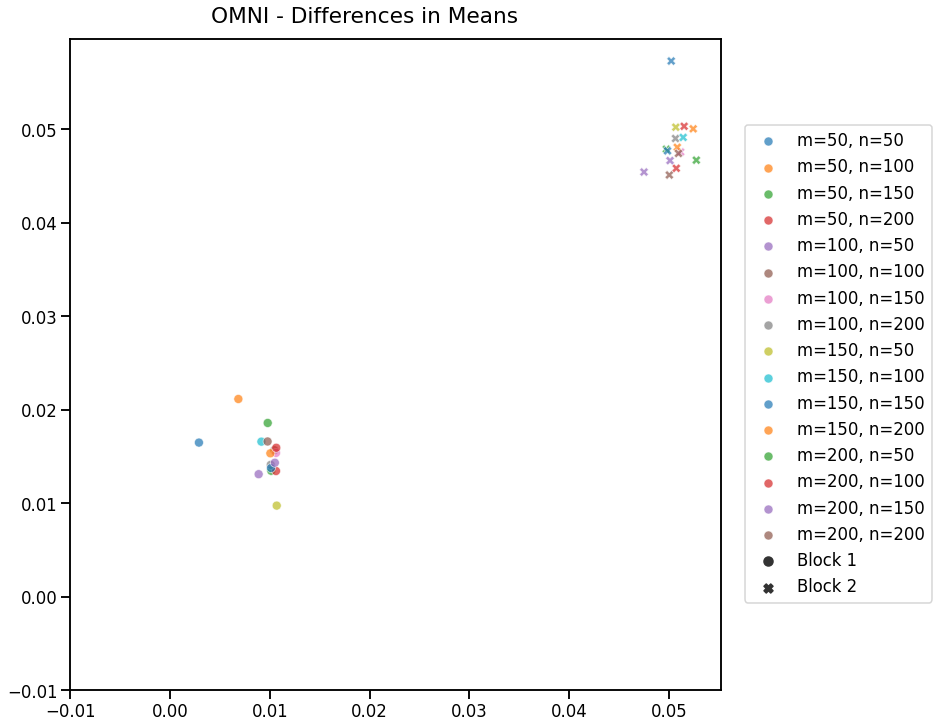

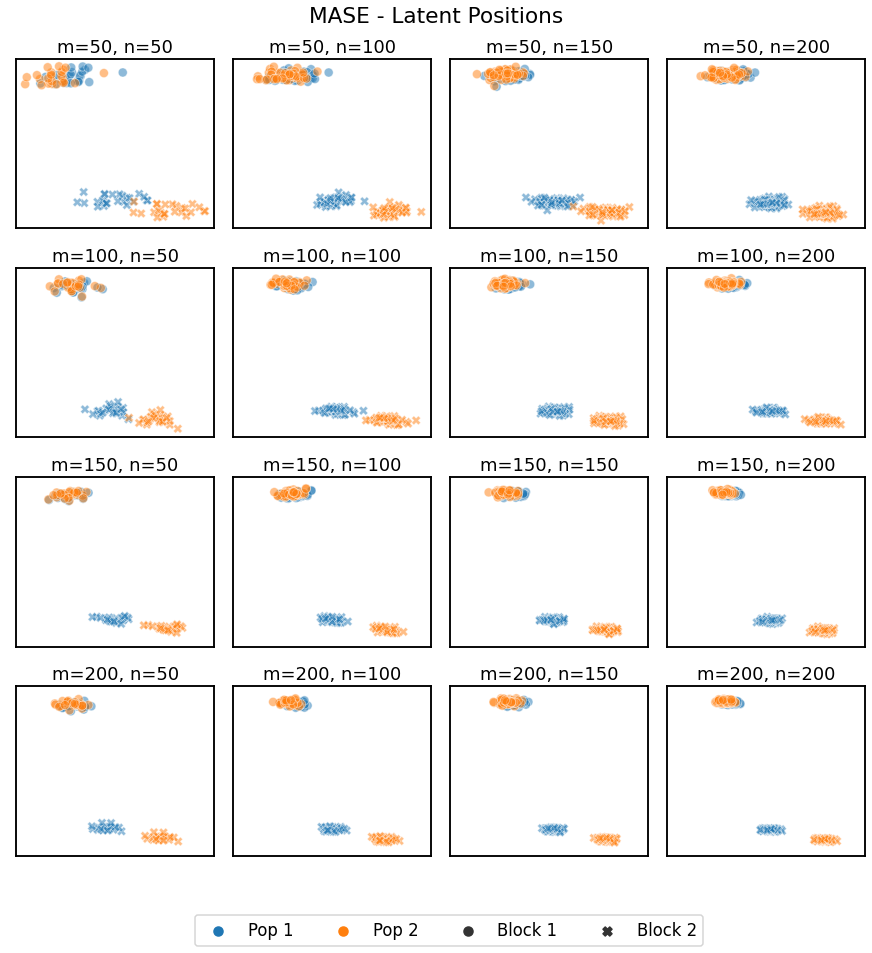

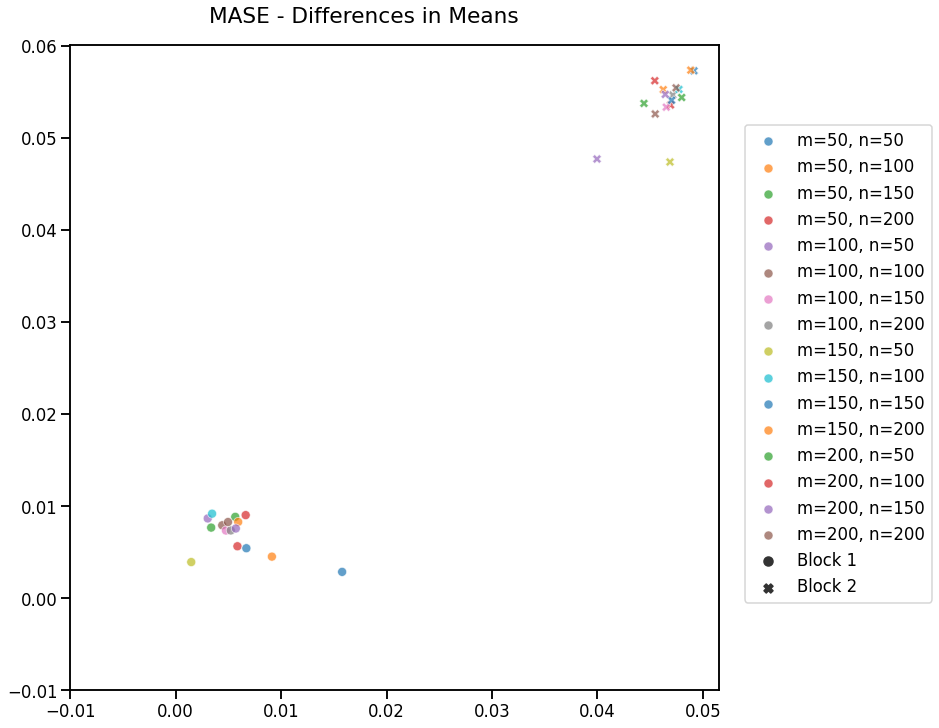

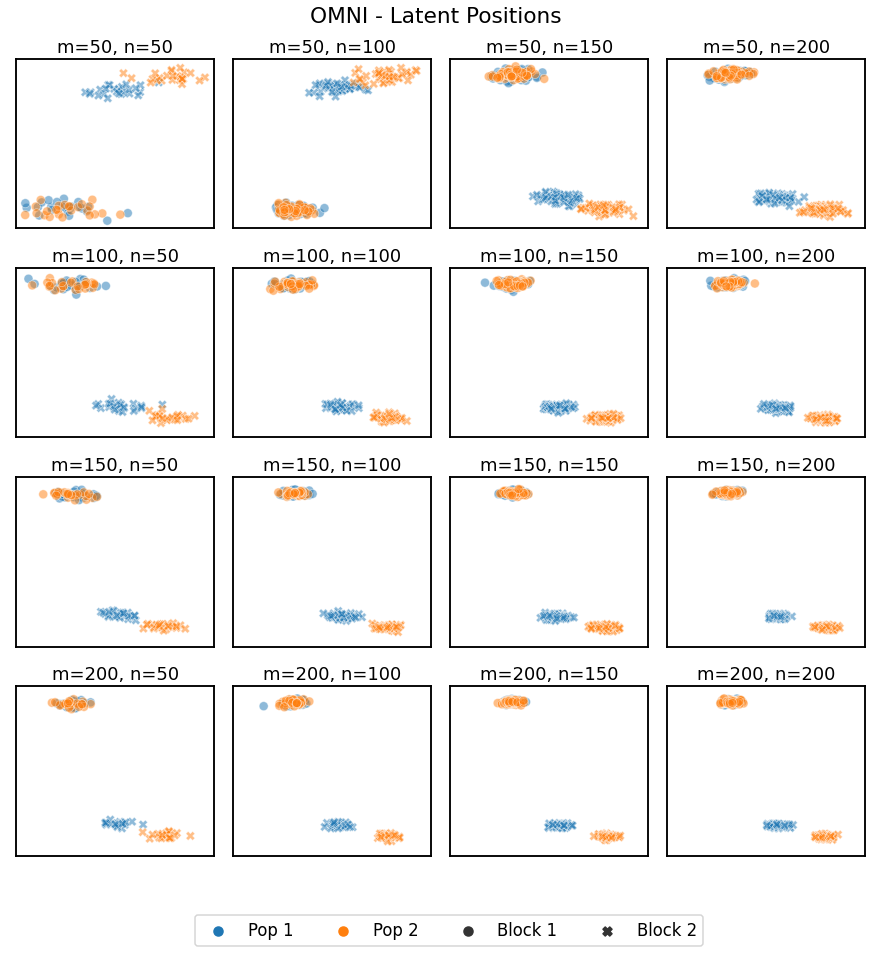

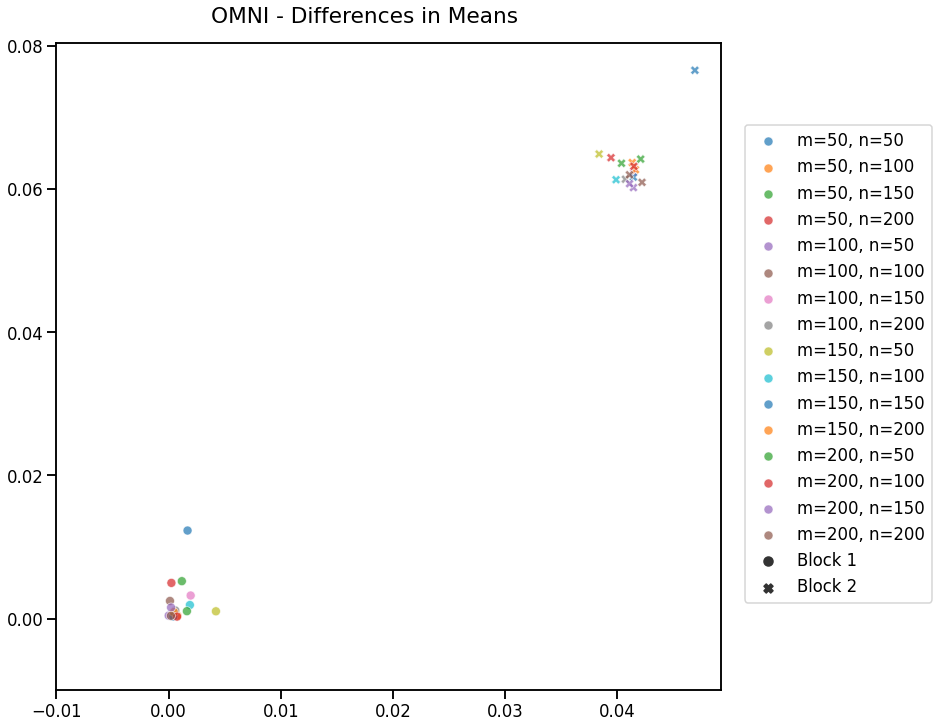

In [100]:
p = .5
effect_sizes = .2
# num_graphs = [50, 100, 150, 200]
# block_sizes = [50, 100, 150, 200]

num_graphs = [25, 50, 75, 100]
block_sizes = [25, 50, 75, 100]

for generate_func in [generate_graphs_1, generate_graphs_4]:
    for method in ['mase', 'omni']:
        ncols = len(num_graphs)
        nrows=len(block_sizes)

        fig, axes = plt.subplots(
            ncols=ncols, 
            nrows=nrows, 
            figsize=(3*nrows, 3*ncols), 
            constrained_layout=True, 
            sharey=True, sharex=True)

        fig2, axes2 = plt.subplots(
            figsize=(10, 10), 
            constrained_layout=True, 
        )

        for i in range(len(num_graphs)):
            for j in range(len(block_sizes)):
                m = num_graphs[i]
                n = block_sizes[j]

                plot(
                    generate_func, p, effect_sizes, 
                    num_graphs=m, 
                    block_size=n, 
                    ax=axes[i, j], 
                    ax2=axes2,
                    title=f"m={m * 2}, n={n * 2}", 
                    method=method
                )

                handles, labels = axes[i, j].get_legend_handles_labels()
                axes[i, j].get_legend().remove()


        legend = fig.legend(
            handles, 
            labels,
            ncol = 7, 
            loc='lower center',
            bbox_to_anchor=(.515, -0.1),
            bbox_transform=fig.transFigure
        )

        fig.suptitle(f"{method.upper()} - Latent Positions")

        # remove the x and y ticks
        for a in axes.ravel():
            a.set_xticks([])
            a.set_yticks([])


        axes2.set_xlim(-.01)
        axes2.set_ylim(-.01)
        handles, labels = axes2.get_legend_handles_labels()
        axes2.get_legend().remove()

        handles2 = handles[::3]
        labels2 = labels[::3]
        

        handles = handles2 + handles[1:3]
        labels = labels2 + labels[1:3]
        legend = fig2.legend(
            handles, 
            labels,
            ncol = 1, 
            loc='right',
            bbox_to_anchor=(1.3, .5),
            bbox_transform=fig2.transFigure
        )
        
        fig2.suptitle(f"{method.upper()} - Differences in Means")


        fig.savefig(f"figures/{generate_func.__name__}_{method}_latent_positions.png", 
                    dpi=300, bbox_inches='tight')
        fig2.savefig(f"figures/{generate_func.__name__}_{method}_latent_diffs.png", 
                     dpi=300, bbox_inches='tight')

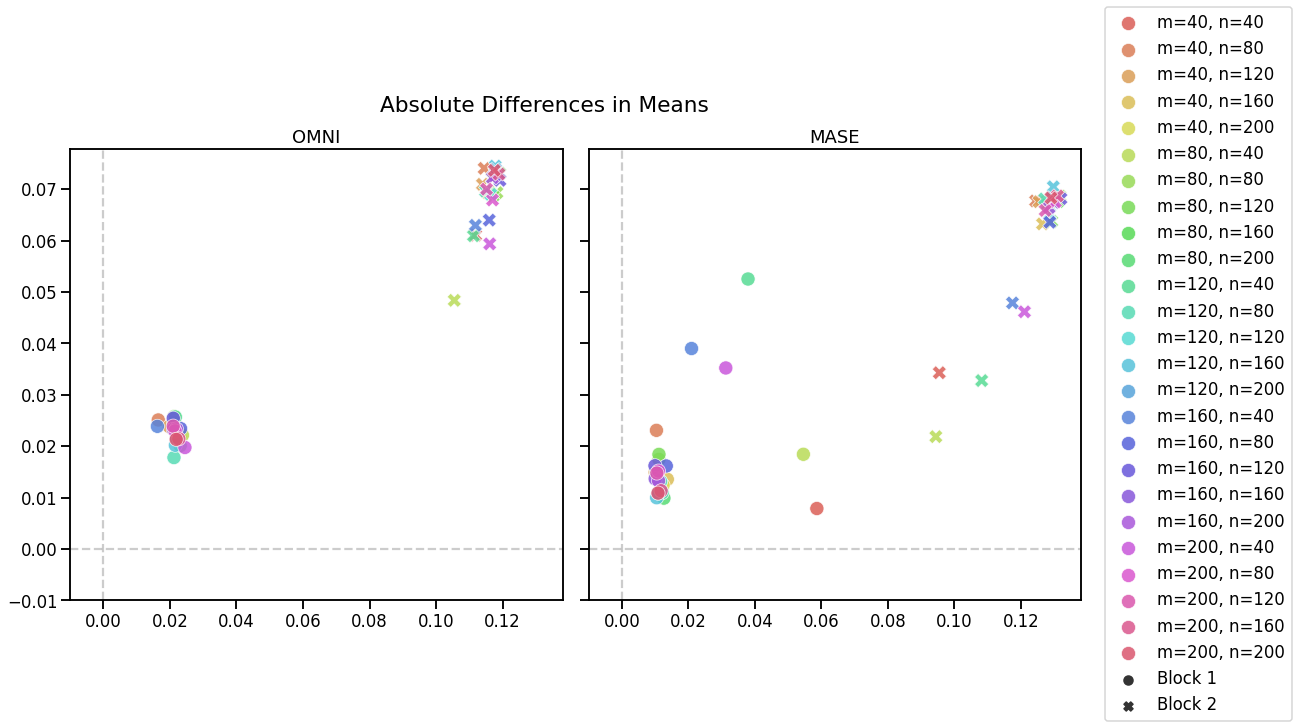

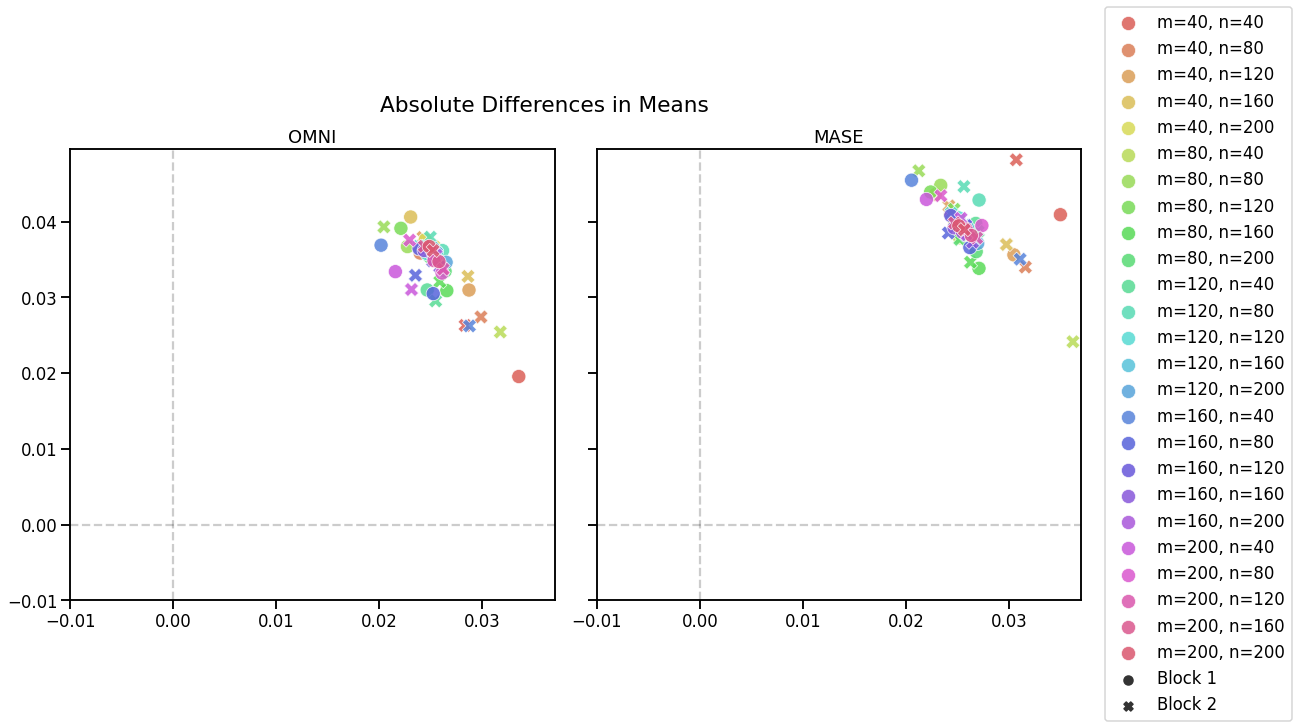

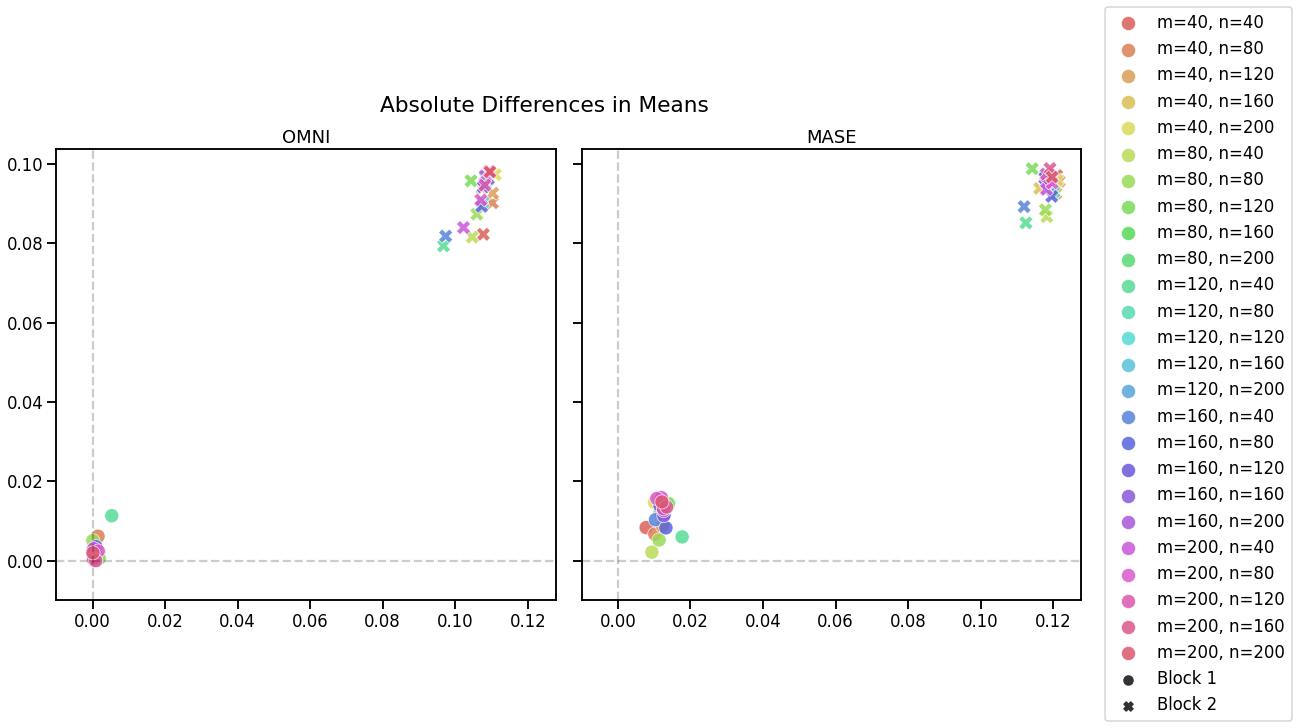

In [61]:
p = .25

num_graphs = np.linspace(0, 100, 6, dtype=int)[1:]
block_sizes = np.linspace(0, 100, 6, dtype=int)[1:]

# num_graphs = [25, 50]
# block_sizes = [25, 50]

for generate_func in [generate_graphs_1, generate_graphs_2, generate_graphs_4]:
    if generate_func.__name__ == 'generate_graphs_2':
        effect_size = 15
    else:
        effect_size = 1

    
    ncols = len(num_graphs)
    nrows = len(block_sizes)
    
    colors = sns.color_palette("hls", ncols * nrows)
    sns.set_context('talk')
    
    fig, axes = plt.subplots(
        ncols=2,
        figsize=(15, 7.5), 
        constrained_layout=True, 
        sharex=True,
        sharey=True
    )
    
    counter = 0
    for i in range(len(num_graphs)):
        for j in range(len(block_sizes)):
            m = num_graphs[i]
            n = block_sizes[j]

            plot2(
                generate_func, p, effect_size,
                num_graphs=m, 
                block_size=n, 
                axes=axes, 
                label=f"m={m * 2}, n={n * 2}",
                color = colors[counter]        
            )

            handles, labels = axes[0].get_legend_handles_labels()
            counter += 1
            
    legend = fig.legend(
        handles[::3] + handles[-2:], 
        labels[::3] + labels[-2:],
        ncol = 1, 
        loc='right',
        bbox_to_anchor=(1.2, .5),
        bbox_transform=fig.transFigure
    )

    fig.suptitle(f"Absolute Differences in Means")

    axes[0].set_xlim(-.01)
    axes[0].set_ylim(-.01)
    
    for a in axes:
        a.get_legend().remove()
        
        a.axvline(ls='--', alpha=.2, c='k')
        a.axhline(ls='--', alpha=.2, c='k')
        
    fig.savefig(f"figures/{generate_func.__name__}_latent_diffs.png", 
                     dpi=300, bbox_inches='tight')